In [56]:
import tensorflow as tf
from numpy import savez_compressed, load
from os import listdir
from keras.models import load_model
from tensorflow import keras
import matplotlib.pyplot as plt
from PIL import Image 
import numpy as np
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import Sequential, Model
from keras.layers import *
from keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam
from numpy.random import randn
from numpy.random import randint
from numpy import zeros
from keras.preprocessing.image import load_img, img_to_array
from numpy.random import random
from keras import backend
from numpy import vstack
import numpy as np
from keras.datasets.mnist import load_data
from numpy.random import rand 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
def load_data(size=(256,256)):
  src_list, target_list = list(), list()
  for filename in listdir("/content/drive/My Drive/dataset/photos"):
    pixels = load_img("/content/drive/My Drive/dataset/photos" + "/" + filename, target_size=size)
    pixels = img_to_array(pixels)
    src_list.append(pixels)
    pixels = load_img("/content/drive/My Drive/dataset/sketches" + "/" + filename, target_size=size)
    pixels = img_to_array(pixels)
    target_list.append(pixels)
  return [np.asarray(src_list), np.asarray(target_list)]

In [3]:

[src_list, target_list] = load_data()
file_name="photo_sketch_pairs.npz"
savez_compressed(file_name, src_list,target_list)


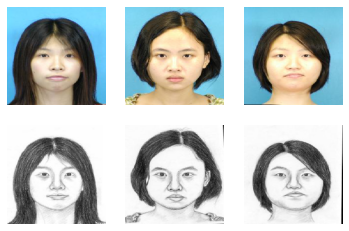

In [4]:
data = load("/content/photo_sketch_pairs.npz")
src_img , target_img = data['arr_0'], data['arr_1']
for i in range(3):
  plt.subplot(2,3,1+i)
  plt.axis('off')
  plt.imshow(src_img[i].astype('uint8'))
for i in range(3):
  plt.subplot(2,3,1+3+i)
  plt.axis('off')
  plt.imshow(target_img[i].astype('uint8'))
plt.show()


In [13]:
def discriminator_model(input_shape):
  weights_init = RandomNormal(stddev=0.02)
  input_src_img = Input(shape=input_shape)
  input_target_img = Input(shape=input_shape)
  merged = Concatenate()([input_src_img,input_target_img])
  d = Conv2D(64,(4,4),strides=(2,2),padding="same", kernel_initializer=weights_init)(merged)
  d = LeakyReLU(alpha=0.2)(d)

  d = Conv2D(128,(4,4),strides=(2,2),padding="same", kernel_initializer=weights_init)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)

  d = Conv2D(256,(4,4),strides=(2,2),padding="same", kernel_initializer=weights_init)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)

  d = Conv2D(512,(4,4),strides=(2,2),padding="same", kernel_initializer=weights_init)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)

  d = Conv2D(512,(4,4),padding="same", kernel_initializer=weights_init)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)

  d = Conv2D(1,(4,4),padding="same", kernel_initializer=weights_init)(d)
  patch = Activation('sigmoid')(d)
  model = Model([input_src_img,input_target_img], patch)
  optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss="binary_crossentropy",optimizer=optimizer,loss_weights=[0.5])
  return model

In [14]:
def encoder_block(layer_in,n_filters,batch_norm = True):
  weights_init = RandomNormal(stddev=0.02)
  g = Conv2D(n_filters,(4,4), strides=(2,2),padding="same",kernel_initializer=weights_init)(layer_in)
  if batch_norm :
    g = BatchNormalization()(g, training=True)
  g = LeakyReLU(alpha=0.2)(g)
  return g 

In [15]:
def decoder_block(layer_in, skip_in,n_filters,dropout = True):
  weights_init = RandomNormal(stddev=0.02)
  g = Conv2DTranspose(n_filters,(4,4),strides=(2,2),padding="same",kernel_initializer=weights_init)(layer_in)
  g = BatchNormalization()(g, training = True)
  if dropout :
    g = Dropout(0.5)(g, training=True)
  g = Concatenate()([g,skip_in])
  g = Activation('relu')(g)
  return g

In [16]:
def generator_model(image_shape=(256,256,3)):
  weights_init = RandomNormal(stddev=0.02)
  input_image = Input(shape=image_shape)
  e1 = encoder_block(input_image,64, batch_norm=False)
  e2 = encoder_block(e1,128)
  e3 = encoder_block(e2,256)
  e4 = encoder_block(e3,512)
  e5 = encoder_block(e4,512)
  e6 = encoder_block(e5,512)
  e7 = encoder_block(e6,512)
  # Bottle Neck layer
  b = Conv2D(512, (4,4),strides=(2,2),padding="same",kernel_initializer=weights_init)(e7)
  b = Activation('relu')(b)
  d1 = decoder_block(b,e7,512)
  d2 = decoder_block(d1,e6,512)
  d3 = decoder_block(d2,e5,512)
  d4 = decoder_block(d3,e4,512, dropout=False)
  d5 = decoder_block(d4,e3,256, dropout=False)
  d6 = decoder_block(d5,e2,128, dropout=False)
  d7 = decoder_block(d6,e1,64, dropout=False)
  g = Conv2DTranspose(3,(4,4),strides=(2,2), padding="same", kernel_initializer=weights_init)(d7)
  output_image = Activation("tanh")(g)
  model = Model(input_image,output_image)
  return model


In [17]:
def gan_model(generator, discriminator, image_shape):
  discriminator.trainable = False
  input_src = Input(shape=image_shape)
  generator_output = generator(input_src)
  discriminator_output = discriminator([input_src, generator_output])
  model = Model(input_src,[discriminator_output, generator_output])
  optimizer = Adam(learning_rate=0.0002,beta_1=0.5)
  model.compile(loss=["binary_crossentropy","mae"], optimizer = optimizer,loss_weights=[1,100])
  return model

In [18]:
def load_real_samples(npz_file):
  data = load("/content/photo_sketch_pairs.npz")
  s,t = data["arr_0"], data["arr_1"]
  s = (s-127.5) /127.5
  t = (t-127.5) /127.5
  return [s,t]

In [19]:
def generate_real_samples(dataset, n_samples, patch_shape):
  s,t = dataset
  idx = randint(0,s.shape[0], n_samples)
  src,target = s[idx], t[idx]
  y = np.ones((n_samples,patch_shape,patch_shape,1))
  return [src, target],y


In [20]:
def generate_fake_samples(generator,source,patch_shape):
  target = generator.predict(source)
  y = np.zeros((len(target), patch_shape,patch_shape,1))
  return target,y

In [21]:
def summarize_performance(epoch, generator, discriminator,dataset, n_samples=3):
  [src_x_real, target_x_real],_ = generate_real_samples(dataset,n_samples,1)
  target_fake,_ = generate_fake_samples(generator,src_x_real,1)
  src_x_real = (src_x_real + 1) / 2.0
  target_x_real = (target_x_real + 1) / 2.0
  target_fake = (target_fake + 1) / 2.0
  for i in range(n_samples):
    plt.subplot(3,n_samples,1+i)
    plt.axis('off')
    plt.imshow(src_x_real[i])
  for i in range(n_samples):
    plt.subplot(3,n_samples,1+n_samples+i)
    plt.axis('off')
    plt.imshow(target_x_real[i])
  for i in range(n_samples):
    plt.subplot(3,n_samples,1+n_samples * 2+i)
    plt.axis('off')
    plt.imshow(target_fake[i])
  file_name = "generated_image_%06d.png" % (epoch+1)
  plt.savefig(file_name)
  plt.close()
  model_name = "generated_model_%06d.h5" % (epoch+1)
  generator.save(model_name)
  print("<------------------------------------------SAVED------------------------------------------>")

In [57]:
def train_gan(generator, discriminator, gan, dataset,n_epochs=100, batch_size=1):
  n_patch = discriminator.output_shape[1]
  src,target = dataset
  
  batches_per_epoch = int(len(src)/batch_size)
  n_steps = batches_per_epoch * n_epochs
  
  for i in range(n_steps):

    [src_real,target_real],y_real = generate_real_samples(dataset, batch_size,n_patch)
    d_loss_real = discriminator.train_on_batch([src_real,target_real], y_real)
    target_fake,y_fake = generate_fake_samples(generator,src_real,n_patch)
    d_loss_fake = discriminator.train_on_batch([src_real,target_fake], y_fake)
    gan_loss,_,_= gan.train_on_batch(src_real,[y_real,target_real])
    print("Epoch " + str(i) + " d_real " + str(d_loss_real) + " d_fake " + str(d_loss_fake) + " gan_loss " + str(gan_loss))
    if (i+1) % (batches_per_epoch * 5) == 0 :
      summarize_performance(i, generator, discriminator,dataset)


In [59]:
dataset = load_real_samples("/content/photo_sketch_pairs.npz")
image_shape = dataset[0].shape[1:]
discriminator = discriminator_model(image_shape)
generator = generator_model(image_shape)
gan = gan_model(generator, discriminator,image_shape)
train_gan(generator, discriminator, gan, dataset)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Streaming output truncated to the last 5000 lines.
Epoch 3813 d_real 0.03233168 d_fake 0.13101313 gan_loss 13.889375
Epoch 3814 d_real 0.18434583 d_fake 0.021353263 gan_loss 13.171488
Epoch 3815 d_real 0.018005542 d_fake 0.22041023 gan_loss 12.617481
Epoch 3816 d_real 0.5705784 d_fake 0.05898432 gan_loss 12.911999
Epoch 3817 d_real 0.16601473 d_fake 0.45401782 gan_loss 14.892514
Epoch 3818 d_real 0.048126463 d_fake 0.008902742 gan_loss 15.878949
Epoch 3819 d_real 0.068152204 d_fake 0.010981891 gan_loss 10.946274
Epoch 3820 d_real 0.1704124 d_fake 0.21040247 gan_loss 14.236782
Epoch 3821 d_real 0.519331 d_fake 0.45512784 gan_loss 15.556521
Epoch 3822 d_real 0.039986953 d_fake 0.053541888 gan_loss 15.690237
Epoch 3823 d_real 0.03206527 d_fake 0.043879267 gan_loss 12.249139
Epoch 3824 d_real 0.001859982 d_fake 0.220082 gan_loss 15.747795
Epoch 3825 d_real 0.64504105 d_fake 0.13421874 gan_loss 10.6255665
Epoch 3826 d_real 0.030834503 d_fake 0.0649748 gan_loss 11.759607
Epoch 3827 d_real 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


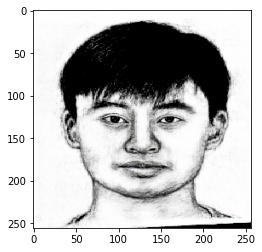

In [69]:
pixels = load_img("/content/78.jpg", target_size=(256,256,3))
pixels = img_to_array(pixels)
pixels = (pixels -127.5)/127.5
pixels = pixels.reshape(1,256,256,3)
output = generator.predict(pixels)
plt.imshow(output[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


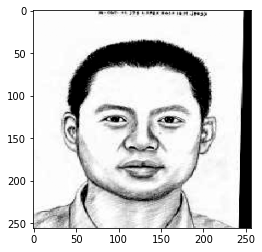

In [61]:
pixels = load_img("/content/drive/My Drive/dataset/sketches" + "/" + "86.jpg", target_size=(256,256,3))
pixels = img_to_array(pixels)
pixels = (pixels -127.5)/127.5
plt.imshow(pixels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


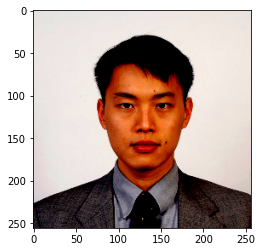